#### Imports

In [2]:
from qutip import *
from qutip.operators import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from cython import *
from sympy import lambdify
import sympy as sp
import copy
import functools

In [3]:
class Empty(object):
    def __init__(self):
        pass

In [4]:
class Model:
    "base class with nice init function"
    default = Empty()
    class_params = []
    
    def update_or_copy(obj, kvargs, params, just_update = False):
        for pk in params:
            if not just_update and pk in obj.default.__dict__:
                obj.__dict__[pk] = copy.copy(obj.default.__dict__[pk])
            if pk in kvargs and not kvargs[pk] is None:
                if isinstance(obj.__dict__[pk], dict):
                    obj.__dict__[pk].update(kvargs[pk])
                else:
                    obj.__dict__[pk] = copy.copy(kvargs[pk])
    def __init__(self, **kvargs):
        self.update_or_copy(kvargs, self.class_params)
    def update(self, **kvargs):
        self.update_or_copy(kvargs, self.class_params, True)

In [5]:
class Pulse(Model):
    '''simple rectangular curved pulse'''
    default = Empty()
    default.params = {
        'f' : 0.1,
        'a':2.5,
        'b':2.5 + 3.92,
        'st':0.001
    }
    default.shape = "f*0.5*(tanh((t-a)/st) - tanh((t-b)/st))"
    default.time = {
        'points' : 100,
        'maxtime' : 10,
        'tlist' : np.linspace(0,10,100)
    }
    class_params = ['params','time','shape']
    
    def function(self):
        params = set(self.params.keys())
        params.add('t')
        return lambdify(params, self.shape, 'numpy')
    def function_t(self,offset = 0):
        spf = sp.sympify(self.shape) + offset
        tosubs = []
        for k,v in self.params.items():
            tosubs.append((sp.symbols(k),v))
        new_spf = spf.subs(tosubs)
        return lambdify({'t'},str(new_spf),'numpy') 
    def timelist(self):
        self.time['tlist'] = np.linspace(0,self.time['maxtime'],self.time['points'])
        return self.time['tlist']
    def plot(self, title = 'Pulse', ax = None):
        if ax is None:
            fig, ax = plt.subplots(1,1, figsize=(13,5), sharey=True, dpi =600)
        ax.set_title(title)
        labels = ['pulse']
        params_for_graph = dict(self.params)
        params_for_graph['t'] = self.timelist()
        ax.plot(self.timelist(), self.function()(**params_for_graph), label=(labels[0]), linewidth = 1 )
        ax.legend(bbox_to_anchor = [1,1],loc = "upper right")
        ax.set_xlabel('Time')
        ax.set_ylabel('Magnitude')


In [6]:
class ConstantPulse(Pulse):
    default = Empty()
    default.params = {
        'f' : 0
    }
    default.shape = "f"
    default.time = {
        'points' : 100,
        'maxtime' : 10,
        'tlist' : np.linspace(0,10,100)
    }
    class_params = ['params','time','shape']

In [7]:
class Vis2D(Model):
    def plot(self, title = 'Qubit',fig = None, ax = None, style = '-'):
        if ax == None:
            fig, ax = plt.subplots(1,1, figsize=(4,3), sharey=True, dpi =600)
        ax.set_title(title);
        labels = ['$\sigma_x(t)$','$\sigma_y(t)$','$\sigma_z(t)$']
        clr = ['b','g','r']
        for idx, op in enumerate(self.result.expect):
            ax.plot(self.timelist(), op,clr[idx] + style, label=(labels[idx]), linewidth = 3 )
            #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
            #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
            ax.set_ylim(-1.2,1.2)

        ax.legend(bbox_to_anchor = [1,1],loc = "upper right")
        ax.set_xlabel('Time')

        ax.set_ylabel('Occupation probability')
        return fig,ax

In [6]:
class Original2D(Vis2D):
    '''2 dimensional model without RWA / not in RF'''
    default = Empty()
    default.params = {
        'Eq' : 1,
        'psi0' : basis(2,0)
    }
    
    default.pulse = [
        Pulse(shape = "f*(cos(w*t + phase))*0.5*(tanh((t-a)/st) - tanh((t-b)/st))", params = {'phase' : 0, 'w' : default.params['Eq']}),
        Pulse(shape = "f*(sin(w*t + phase))*0.5*(tanh((t-a)/st) - tanh((t-b)/st))", params = {'phase' : 0, 'w' : default.params['Eq']})
    ]
    default.Hf = [
        sigmaz()/2,
        sigmax()/2,
        sigmay()/2
    ]
    class_params = ['params','pulse','Hf']
    
    def update_pulse(self, **new_params):
        for p in self.pulse:
            p.update(params = new_params['params'] if 'params' in new_params else None , 
                     time = new_params['time'] if 'time' in new_params else None, 
                     shape = new_params['shape'] if 'shape' in new_params else None)
    def HTD(self):
        "time dependendent Hamiltonian"
        return [self.params['Eq']*self.Hf[0],[self.Hf[1],self.pulse[0].shape],[self.Hf[2],self.pulse[1].shape]]
    def args(self):
        arguments = {}
        for p in self.pulse:
            arguments.update(p.params)
        return arguments
    
    def timelist(self):
        return self.pulse[0].timelist()
    
    def solve(self, expected_ops = [sigmax(),sigmay(),sigmaz()]):
        self.result = mesolve(self.HTD(),self.params['psi0'], self.timelist(), [],expected_ops, args = self.args(),options= Options(nsteps=10000), progress_bar=True)

In [7]:
class Simple2D(Original2D):
    '''2 dimensional model without RWA / in RF'''
    default = Empty()
    default.params = {
        'Eq' : 1,
        'psi0' : basis(2,0)
    }
    
    default.pulse = [
        Pulse(shape = "f*(cos(phase) + cos(2*w*t + phase))*0.5*(tanh((t-a)/st) - tanh((t-b)/st))", params = {'phase' : 0, 'w' : default.params['Eq']}),
        Pulse(shape = "f*(-sin(phase) + sin(2*w*t + phase))*0.5*(tanh((t-a)/st) - tanh((t-b)/st))", params = {'phase' : 0, 'w' : default.params['Eq']})
    ]
    default.Hf = [
        sigmax()/2,
        sigmay()/2
    ]
    class_params = ['params','pulse','Hf']
    
      
    
    def HTD(self):
        "time dependendent Hamiltonian"
        return [[self.Hf[0],self.pulse[0].shape],[self.Hf[1],self.pulse[1].shape]]
    
   

In [8]:
class RWA2D(Simple2D):
    "2 dimensional model with RWA"
    default = Empty()
    default.params = {
        'Eq' : 1,
        'psi0' : basis(2,0)
    }
    default.pulse = [
        Pulse(shape = "f*0.5*(tanh((t-a)/st) - tanh((t-b)/st))*cos(phase)", params = {'phase' : 0}),
        Pulse(shape = "f*0.5*(tanh((t-a)/st) - tanh((t-b)/st))*sin(phase)", params = {'phase' : 0})
    ]
    default.Hf = [
        sigmay()/2,
        sigmax()/2
    ]
    class_params = ['params','pulse','Hf']
    

In [9]:
a = Simple2D()
a.update_pulse(params={'f':0.04})
a.update_pulse(time = {'maxtime' : 50,'points':1000},params={'b' : a.pulse[0].params['a'] + np.pi/2 / a.pulse[0].params['f']})

{'params': {'f': 0.04}, 'time': None, 'shape': None}
{'params': {'f': 0.04}, 'time': None, 'shape': None}
{'params': {'b': 41.769908169872416}, 'time': {'points': 1000, 'maxtime': 50}, 'shape': None}
{'params': {'b': 41.769908169872416}, 'time': {'points': 1000, 'maxtime': 50}, 'shape': None}


In [10]:
a.solve()


10.0%. Run time:   0.05s. Est. time left: 00:00:00:00
20.0%. Run time:   0.09s. Est. time left: 00:00:00:00
30.0%. Run time:   0.13s. Est. time left: 00:00:00:00
40.0%. Run time:   0.16s. Est. time left: 00:00:00:00
50.0%. Run time:   0.19s. Est. time left: 00:00:00:00
60.0%. Run time:   0.23s. Est. time left: 00:00:00:00
70.0%. Run time:   0.26s. Est. time left: 00:00:00:00
80.0%. Run time:   0.29s. Est. time left: 00:00:00:00
90.0%. Run time:   0.31s. Est. time left: 00:00:00:00
Total run time:   0.33s


{'time': None, 'params': {'f': 0.08}, 'shape': None}
{'time': None, 'params': {'f': 0.08}, 'shape': None}
10.0%. Run time:   0.03s. Est. time left: 00:00:00:00
20.0%. Run time:   0.07s. Est. time left: 00:00:00:00
30.0%. Run time:   0.10s. Est. time left: 00:00:00:00
40.0%. Run time:   0.14s. Est. time left: 00:00:00:00
50.0%. Run time:   0.18s. Est. time left: 00:00:00:00
60.0%. Run time:   0.21s. Est. time left: 00:00:00:00
70.0%. Run time:   0.26s. Est. time left: 00:00:00:00
80.0%. Run time:   0.30s. Est. time left: 00:00:00:00
90.0%. Run time:   0.33s. Est. time left: 00:00:00:00
Total run time:   0.34s


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


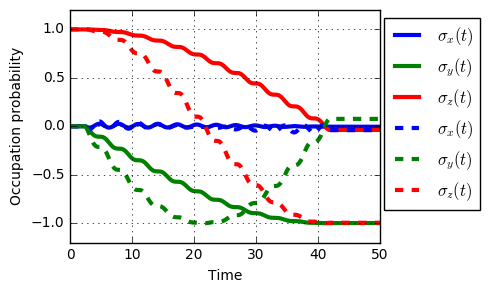

In [250]:
fig,ax = a.plot()
ax.set_title("")
ax.set_ylabel("")
ax.grid()
a.update_pulse(params={'f':0.08})
#a.update_pulse(time = {'maxtime' : 50,'points':1000},params={'b' : a.pulse[0].params['a'] + np.pi/2 / a.pulse[0].params['f']})
a.solve()
a.plot('',fig,ax,'--')
ax.legend(bbox_to_anchor = [1.35,1],loc = 'upper right')
fig.show()
plt.savefig('simple-pulse-2f.pdf',bbox_inches = 'tight')

{'time': None, 'params': {'f': 0.08}, 'shape': None}
{'time': None, 'params': {'f': 0.08}, 'shape': None}
10.0%. Run time:   0.05s. Est. time left: 00:00:00:00
20.0%. Run time:   0.10s. Est. time left: 00:00:00:00
30.0%. Run time:   0.15s. Est. time left: 00:00:00:00
40.0%. Run time:   0.19s. Est. time left: 00:00:00:00
50.0%. Run time:   0.22s. Est. time left: 00:00:00:00
60.0%. Run time:   0.26s. Est. time left: 00:00:00:00
70.0%. Run time:   0.29s. Est. time left: 00:00:00:00
80.0%. Run time:   0.33s. Est. time left: 00:00:00:00
90.0%. Run time:   0.36s. Est. time left: 00:00:00:00
Total run time:   0.38s


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


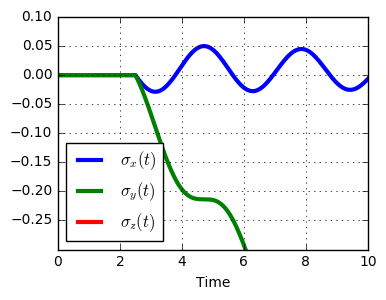

In [208]:
fig,ax = a.plot()
ax.set_title("")
ax.set_ylabel("")
ax.grid()
ax.set_xlim([0,10])
ax.set_ylim([-0.3,0.1])
ax.legend(bbox_to_anchor = [0,0],loc = "lower left")

{'time': {'points': 200, 'maxtime': 6.283185307179586}, 'params': {'f': 0}, 'shape': None}
{'time': {'points': 200, 'maxtime': 6.283185307179586}, 'params': {'f': 0}, 'shape': None}
10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.0%. Run time:   0.03s. Est. time left: 00:00:00:00
30.0%. Run time:   0.04s. Est. time left: 00:00:00:00
40.0%. Run time:   0.06s. Est. time left: 00:00:00:00
50.0%. Run time:   0.06s. Est. time left: 00:00:00:00
60.0%. Run time:   0.07s. Est. time left: 00:00:00:00
70.0%. Run time:   0.08s. Est. time left: 00:00:00:00
80.0%. Run time:   0.09s. Est. time left: 00:00:00:00
90.0%. Run time:   0.10s. Est. time left: 00:00:00:00
Total run time:   0.12s


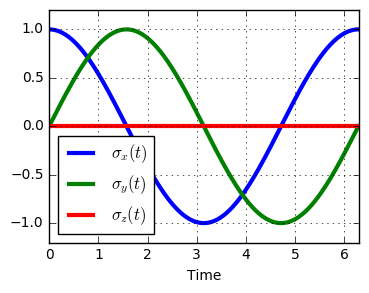

In [138]:
b = Original2D()
b.params['psi0'] = basis(2,1) + basis(2,0)
b.update_pulse(params={'f':0},time={'maxtime':np.pi*2,"points":200})
b.solve()
fig,ax = b.plot()
ax.set_title("")
ax.set_ylabel("")
ax.grid()
ax.set_xlim([0,6.3])
ax.legend(bbox_to_anchor = [0,0],loc = "lower left")
plt.savefig('simple-free-2d.pdf',bbox_inches="tight")

In [104]:
from colour import Color
blue = Color("blue")
colors = list(blue.range_to(Color("green"),len(b.result.expect[0])))

In [11]:
b = Original2D()
b.params['psi0'] = basis(2,1) + basis(2,0)
b.update_pulse(params={'f':0},time={'maxtime':np.pi*2,"points":50})
b.solve()

{'params': {'f': 0}, 'time': {'points': 50, 'maxtime': 6.283185307179586}, 'shape': None}
{'params': {'f': 0}, 'time': {'points': 50, 'maxtime': 6.283185307179586}, 'shape': None}
10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.01s. Est. time left: 00:00:00:00
30.0%. Run time:   0.01s. Est. time left: 00:00:00:00
40.0%. Run time:   0.01s. Est. time left: 00:00:00:00
50.0%. Run time:   0.01s. Est. time left: 00:00:00:00
60.0%. Run time:   0.02s. Est. time left: 00:00:00:00
70.0%. Run time:   0.02s. Est. time left: 00:00:00:00
80.0%. Run time:   0.02s. Est. time left: 00:00:00:00
90.0%. Run time:   0.03s. Est. time left: 00:00:00:00
Total run time:   0.03s


TypeError: 'Figure' object is not iterable

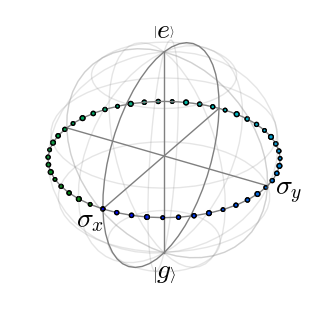

In [181]:
fig,ax = plt.subplots(1,1,figsize = (3,3),dpi=600)
s2 = Bloch()
s2.fig = fig
s2.point_color = [c.hex_l for c in colors]
s2.point_marker = ['.']
s2.zlabel = [r'$\left|e\right>$',r'$\left|g\right>$']
s2.ylabel = [r'$\sigma_y$','']
s2.xlabel = [r'$\sigma_x$','']
s2.sphere_alpha = 0
for x,y,z in zip(b.result.expect[0],b.result.expect[1],b.result.expect[2]):
    s2.add_points([x,y,z])
cb = colorbar.ColorbarBase(ax)
s2.show()
s2.save('bloch-2pi.pdf')

NameError: name 'y_projection_2D' is not defined

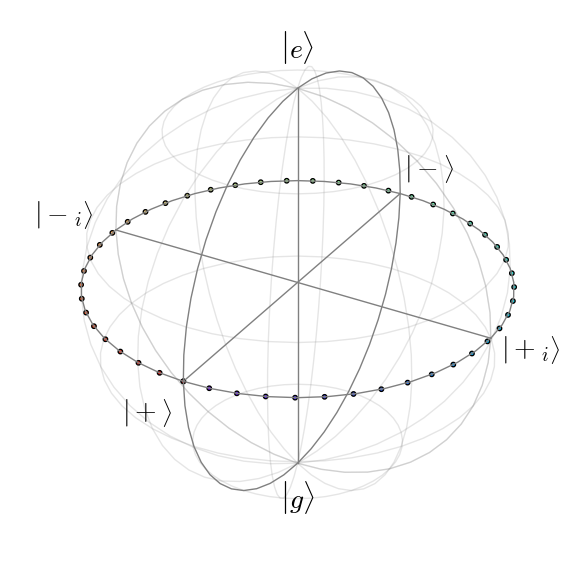

In [15]:
import matplotlib
Ts = b.timelist()
import matplotlib.cm as cm
nrm=matplotlib.colors.Normalize(0,Ts[-1])
colors=cm.rainbow(nrm(Ts))

fig = plt.figure(figsize=(7,7))
axes = fig.add_axes([0.1, 0.2, 0.8, 0.8], projection="3d")
sph = Bloch(fig=fig, axes=axes)
sph.sphere_alpha = 0
sph.zlabel = [r'$\left|e\rightangle\right.$', r"$\left|g\rightangle\right.$"]
sph.xlpos = [1.3, -1.3]
sph.xlabel = [r'$\left.|+\right\rangle$', r"$\left.|-\right\rangle$"]
sph.ylpos = [1.2, -1.3]
sph.ylabel = [r'$\left.|+_i\right\rangle$', r"$\left.|-_i\right\rangle$"]
sph.xlpos = [1.3, -1.3]
sph.point_size=[40]
# axes.view_init(elev=10)

sph.point_color = list(colors)
sph.point_marker=['.']
sph.add_points(b.result.expect, meth = 'm')
# sph.add_points([x_projection, y_projection, z_projection], meth='m')
sph.render(fig, axes)
axes.scatter(y_projection_2D, -x_projection_2D, z_projection_2D, edgecolors="none", c=list(colors))
m = cm.ScalarMappable(cmap=cm.viridis, norm=nrm)
m.set_array(Ts)
m.set_clim(0, Ts[-1])
position=fig.add_axes([0.2,0.2,0.63,0.035])
cb = fig.colorbar(m, orientation='horizontal', cax=position)
cb.set_label("Time, ns")
cb.set_ticks(np.linspace(0,round(Ts[-1]),6))
# plt.savefig("2d_rabi_example_bloch_pure_Y.pdf", bbox_inches="tight")

In [112]:
import matplotlib.colorbar as colorbar